# Install Dependencies

```
pip install geopandas                  
pip install PySAL                       
pip install descartes 
```


# Download "Countries"

Download the first link under "Admin 0 – Countries" for "Download countries" from http://www.naturalearthdata.com/downloads/10m-cultural-vectors/

Unzip in your downloads directory. (Or any suitable location)


In [63]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import collections

shapefile = os.path.expanduser('~/Downloads/ne_10m_admin_0_countries.shp')

colors = 9
cmap = 'Blues'
figsize = (16, 10)

In [64]:
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

def run_query(query, project='mlab-sandbox'):
    #print query
    client = bigquery.Client(project=project)
    job = client.query(query)

    results = collections.defaultdict(list)
    for row in job.result(timeout=300):
        for key in row.keys():
            results[key].append(row.get(key))

    return pd.DataFrame(results)

In [65]:
gdf = gpd.read_file(shapefile)
gdf = gdf[['ISO_A2', 'CONTINENT', 'geometry']].to_crs('+proj=longlat')
gdf = gdf[gdf.CONTINENT == 'Africa']

gdf.sample(5)

,ISO_A2,CONTINENT,geometry
150,GH,Africa,POLYGON ((-0.1661091709999596 11.1349803670001...
108,ZW,Africa,POLYGON ((25.25978072100012 -17.79410654699998...
21,-99,Africa,"POLYGON ((48.9391119999184 11.24912997616744, ..."
16,KE,Africa,(POLYGON ((34.38118778500007 4.620158386000099...
125,RW,Africa,POLYGON ((29.01536543800011 -2.720711364999957...


# Clients Geolocated Within Africa

In [66]:
count_df = run_query("""
SELECT
  connection_spec.client_geolocation.country_name as country_name,
  connection_spec.client_geolocation.country_code as country_code,
  COUNT(*) as count
FROM
  `measurement-lab.ndt.base`
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-01")
  AND connection_spec.client_geolocation.continent_code = "AF"
GROUP BY
  country_code, country_name
ORDER BY
 country_name, country_code, count desc
""")

In [67]:
count_df.sample(5)

,count,country_code,country_name
29,7465,MA,Morocco
36,41,RE,Réunion
37,50,SN,Senegal
40,55,SO,Somalia
44,4,TG,Togo


In [68]:
count_merged = gdf.merge(count_df, left_on='ISO_A2', right_on='country_code')
count_merged.sample(5)

,ISO_A2,CONTINENT,geometry,count,country_code,country_name
4,TZ,Africa,(POLYGON ((32.9208634850001 -9.407900085999913...,239,TZ,Tanzania
31,LS,Africa,POLYGON ((28.98084558100007 -28.90903533899998...,2,LS,Lesotho
33,GA,Africa,(POLYGON ((13.29456791200008 2.161057841000058...,13,GA,Gabon
5,MA,Africa,POLYGON ((-8.817034779999915 27.66146401100009...,7465,MA,Morocco
27,SZ,Africa,POLYGON ((31.94924320400008 -25.95810434999991...,13,SZ,Eswatini


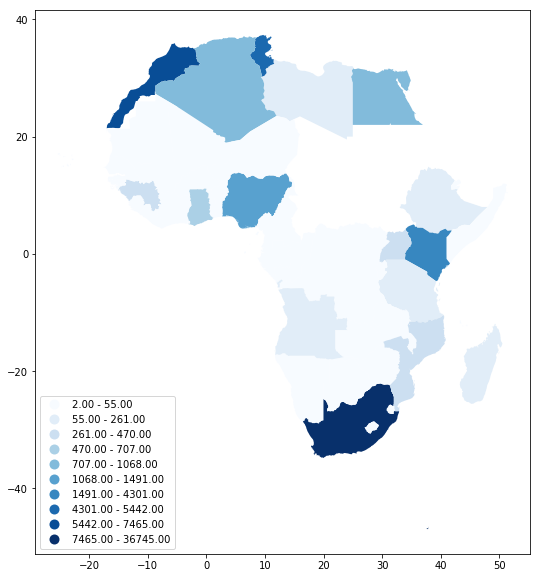

In [69]:
ax = count_merged.dropna().plot(column='count', cmap='Blues', figsize=figsize, scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3})


In [70]:
rates_df = run_query("""
SELECT
  connection_spec.client_geolocation.country_name as country_name,
  connection_spec.client_geolocation.country_code as country_code,
  COUNT(*) as count,
  AVG(8 * (web100_log_entry.snap.HCThruOctetsAcked /
      (web100_log_entry.snap.SndLimTimeRwin +
       web100_log_entry.snap.SndLimTimeCwnd +
       web100_log_entry.snap.SndLimTimeSnd))) AS download_Mbps
       
FROM
  `measurement-lab.ndt.base`
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-01")
  AND connection_spec.client_geolocation.continent_code = "AF"

  AND connection_spec.data_direction = 1
  AND web100_log_entry.snap.HCThruOctetsAcked >= 8192
  AND (web100_log_entry.snap.SndLimTimeRwin +
    web100_log_entry.snap.SndLimTimeCwnd +
    web100_log_entry.snap.SndLimTimeSnd) >= 9000000
  AND (web100_log_entry.snap.SndLimTimeRwin +
    web100_log_entry.snap.SndLimTimeCwnd +
    web100_log_entry.snap.SndLimTimeSnd) < 600000000
  AND web100_log_entry.snap.CongSignals > 0
  AND (web100_log_entry.snap.State = 1 OR
    (web100_log_entry.snap.State >= 5 AND
    web100_log_entry.snap.State <= 11))
  
GROUP BY
  country_code, country_name
ORDER BY
 country_name, country_code, count desc
""")


Text(0.5,1,u'Download Rates (Mbps)')

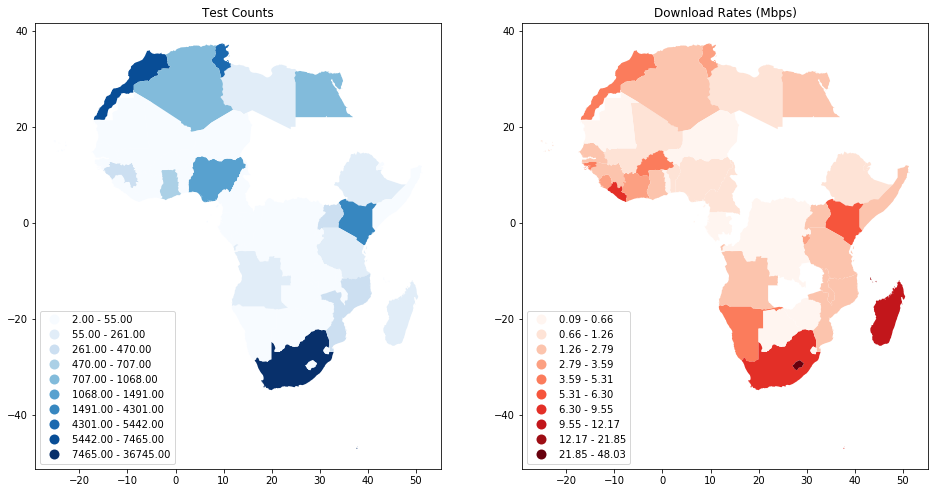

In [71]:
f, ax = plt.subplots(1, 2, figsize=figsize)

rates_merged = gdf.merge(rates_df, left_on='ISO_A2', right_on='country_code')
ax1 = count_merged.dropna().plot(column='count', cmap='Blues', ax=ax[0], figsize=figsize, scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3})
ax2 = rates_merged.dropna().plot(column='download_Mbps', cmap='Reds', ax=ax[1], figsize=figsize, scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3})

ax1.set_title('Test Counts')
ax2.set_title('Download Rates (Mbps)')

In [72]:
type(merged)
type(ax)


numpy.ndarray